# Training a Neural Net on PLAsTICC dataset

Based on [meaninglesslives' public kernel](https://www.kaggle.com/meaninglesslives/simple-neural-net-for-time-series-classification).

See data definitions [here](https://www.kaggle.com/c/PLAsTiCC-2018/data) and detailed information on the study [here](./data/data_note.pdf).

**Table of Contents:**

* [Import Libraries](#Import-Libraries)
* [Load and Transform Data](#Load-and-Transform-Data)
* [Merge in Metadata](#Merge-in-Metadata)
* [Scale the Input](#Scale-the-Input)
* [Pickle the Training Data](#Pickle-the-Training-Data)
* [Set up Training Losses](#Set-up-Training-Losses)
* [Define Keras Model](#Define-Keras-Model)
* [Train the Model](#Train-the-Model)
* [Examine the Confusion Matrix](#Examine-the-Confusion-Matrix)
* [Predictions on the Test Set](#Predictions-on-the-Test-Set)

## Import Libraries

In [65]:
import pandas as pd
import numpy as np
import gc # Garbage collection

## Load and Transform Data

In [66]:
gc.enable()

train = pd.read_csv('../data/training_set.csv', engine='python')
train.head()

,object_id,mjd,passband,flux,flux_err,detected
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


First, create the square of the ratio of flux to error in measuring flux, and the flux times the previous ratio:

In [3]:
train['flux_ratio_sq'] = np.power(train['flux'] / train['flux_err'], 2.0)
train['flux_by_flux_ratio_sq'] = train['flux'] * train['flux_ratio_sq']

Next, create features based on typical aggregate statistics (note, can [apply multiple transforms at once](http://pandas.pydata.org/pandas-docs/stable/groupby.html#applying-multiple-functions-at-once)):

In [4]:
aggs = {
    'mjd': ['min', 'max', 'size'],
    'passband': ['min', 'max', 'mean', 'median', 'std'],
    'flux': ['min', 'max', 'mean', 'median', 'std','skew'],
    'flux_err': ['min', 'max', 'mean', 'median', 'std','skew'],
    'detected': ['mean'],
    'flux_ratio_sq':['sum','skew'],
    'flux_by_flux_ratio_sq':['sum','skew'],
}
agg_train = train.groupby('object_id').agg(aggs)

In [5]:
agg_train.head()

mjd                  passband                       \
                  min         max size      min max      mean median   
object_id                                                              
615        59750.4229  60624.2132  352        0   5  2.457386    2.0   
713        59825.2600  60674.0798  350        0   5  2.400000    2.0   
730        59798.3205  60652.1660  330        0   5  2.336364    2.0   
745        59770.3662  60624.0722  351        0   5  2.378917    2.0   
1124       59750.4229  60624.2132  352        0   5  2.457386    2.0   

                            flux                ...       flux_err            \
                std          min         max    ...            max      mean   
object_id                                       ...                            
615        1.720797 -1100.440063  660.626343    ...      12.845472  4.482743   
713        1.746056   -14.735178   14.770886    ...       9.115748  2.359620   
730        1.758750   -19.159811   47.310059    ...      11.281384  2.471061   
745        1.747328   -15.494463  220.795212    ...      55.892746  2.555576   
1124       1.720797   -16.543753  143.600189    ...      11.383690  2.753004   

                                          detected flux_ratio_sq            \
             median       std       skew      mean           sum      skew   
object_id                                                                    
615        3.835269  1.744747   1.623740  0.946023  2.929669e+06  0.812722   
713        1.998217  1.509888   1.633246  0.171429  5.886068e+03  3.439423   
730        1.990851  1.721134   1.823726  0.069697  4.124452e+03  5.480405   
745        1.819875  3.537324  10.741655  0.173789  9.416165e+04  9.611274   
1124       2.214854  1.933837   1.794938  0.173295  3.432418e+04  7.868462   

          flux_by_flux_ratio_sq             
                            sum       skew  
object_id                                   
615               -9.601766e+08  -1.414322  
713               -2.875087e+04  -3.454554  
730                1.046502e+05   5.989138  
745                1.439125e+07  11.141069  
1124               3.015599e+06   7.908174  

[5 rows x 25 columns]

Fix the column names to only have 1 level:

In [6]:
new_columns = [
    k + '_' + agg for k in aggs.keys() for agg in aggs[k]
]
agg_train.columns = new_columns
agg_train.head()

,mjd_min,mjd_max,mjd_size,passband_min,passband_max,passband_mean,passband_median,passband_std,flux_min,flux_max,...,flux_err_max,flux_err_mean,flux_err_median,flux_err_std,flux_err_skew,detected_mean,flux_ratio_sq_sum,flux_ratio_sq_skew,flux_by_flux_ratio_sq_sum,flux_by_flux_ratio_sq_skew
object_id,,,,,,,,,,,,,,,,,,,,,
615,59750.4229,60624.2132,352,0,5,2.457386,2.0,1.720797,-1100.440063,660.626343,...,12.845472,4.482743,3.835269,1.744747,1.623740,0.946023,2.929669e+06,0.812722,-9.601766e+08,-1.414322
713,59825.2600,60674.0798,350,0,5,2.400000,2.0,1.746056,-14.735178,14.770886,...,9.115748,2.359620,1.998217,1.509888,1.633246,0.171429,5.886068e+03,3.439423,-2.875087e+04,-3.454554
730,59798.3205,60652.1660,330,0,5,2.336364,2.0,1.758750,-19.159811,47.310059,...,11.281384,2.471061,1.990851,1.721134,1.823726,0.069697,4.124452e+03,5.480405,1.046502e+05,5.989138
745,59770.3662,60624.0722,351,0,5,2.378917,2.0,1.747328,-15.494463,220.795212,...,55.892746,2.555576,1.819875,3.537324,10.741655,0.173789,9.416165e+04,9.611274,1.439125e+07,11.141069
1124,59750.4229,60624.2132,352,0,5,2.457386,2.0,1.720797,-16.543753,143.600189,...,11.383690,2.753004,2.214854,1.933837,1.794938,0.173295,3.432418e+04,7.868462,3.015599e+06,7.908174


Create new features that may be useful and clean up those that are no longer needed:

In [7]:
agg_train['mjd_diff'] = agg_train['mjd_max'] - agg_train['mjd_min']
agg_train['flux_diff'] = agg_train['flux_max'] - agg_train['flux_min']
agg_train['flux_dif2'] = (agg_train['flux_max'] - agg_train['flux_min']) / agg_train['flux_mean']
agg_train['flux_w_mean'] = agg_train['flux_by_flux_ratio_sq_sum'] / agg_train['flux_ratio_sq_sum']
agg_train['flux_dif3'] = (agg_train['flux_max'] - agg_train['flux_min']) / agg_train['flux_w_mean']
del agg_train['mjd_max'], agg_train['mjd_min']
agg_train.head()

,mjd_size,passband_min,passband_max,passband_mean,passband_median,passband_std,flux_min,flux_max,flux_mean,flux_median,...,detected_mean,flux_ratio_sq_sum,flux_ratio_sq_skew,flux_by_flux_ratio_sq_sum,flux_by_flux_ratio_sq_skew,mjd_diff,flux_diff,flux_dif2,flux_w_mean,flux_dif3
object_id,,,,,,,,,,,,,,,,,,,,,
615,352,0,5,2.457386,2.0,1.720797,-1100.440063,660.626343,-123.096998,-89.477524,...,0.946023,2.929669e+06,0.812722,-9.601766e+08,-1.414322,873.7903,1761.066406,-14.306331,-327.742307,-5.373326
713,350,0,5,2.400000,2.0,1.746056,-14.735178,14.770886,-1.423351,-0.873033,...,0.171429,5.886068e+03,3.439423,-2.875087e+04,-3.454554,848.8198,29.506064,-20.730002,-4.884564,-6.040676
730,330,0,5,2.336364,2.0,1.758750,-19.159811,47.310059,2.267434,0.409172,...,0.069697,4.124452e+03,5.480405,1.046502e+05,5.989138,853.8455,66.469870,29.315018,25.373110,2.619697
745,351,0,5,2.378917,2.0,1.747328,-15.494463,220.795212,8.909206,1.035895,...,0.173789,9.416165e+04,9.611274,1.439125e+07,11.141069,853.7060,236.289675,26.521968,152.835617,1.546038
1124,352,0,5,2.457386,2.0,1.720797,-16.543753,143.600189,7.145702,1.141288,...,0.173295,3.432418e+04,7.868462,3.015599e+06,7.908174,873.7903,160.143942,22.411225,87.856390,1.822792


Clean up our memory:

In [8]:
del train
gc.collect()

275

## Merge in Metadata 

First, load it:

In [9]:
meta_train = pd.read_csv('../data/training_set_metadata.csv')
meta_train.head()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90


Next, merge it:

In [10]:
full_train = agg_train.reset_index().merge(
    right=meta_train,
    how='outer',
    on='object_id'
)

Split out the target predictions into a vector, and examine unique classes:

In [11]:
if 'target' in full_train:
    y = full_train['target']
    del full_train['target']
classes = sorted(y.unique())

# Taken from Giba's topic : https://www.kaggle.com/titericz
# https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
# with Kyle Boone's post https://www.kaggle.com/kyleboone
class_weight = {
    c: 1 for c in classes
}
for c in [64, 15]:
    class_weight[c] = 2

print('Unique classes : ', classes)

Unique classes :  [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]


Split out object ids into their own df, since they're not predictive (note that double-brackets outputs a df rather than single brackets which would output a series). Also, clean up data that's not used for prediction.

In [12]:
if 'object_id' in full_train:
    oof_df = full_train[['object_id']]
    del full_train['object_id'], full_train['distmod'], full_train['hostgal_specz']
    del full_train['ra'], full_train['decl'], full_train['gal_l'],full_train['gal_b'],full_train['ddf']

Fill NA values with the means of populated data (but don't delete `train_mean` here since we'll need to use it to transform the test data!):

In [13]:
train_mean = full_train.mean(axis=0)
full_train.fillna(train_mean, inplace=True)

,mjd_size,passband_min,passband_max,passband_mean,passband_median,passband_std,flux_min,flux_max,flux_mean,flux_median,...,flux_by_flux_ratio_sq_sum,flux_by_flux_ratio_sq_skew,mjd_diff,flux_diff,flux_dif2,flux_w_mean,flux_dif3,hostgal_photoz,hostgal_photoz_err,mwebv
0,352,0,5,2.457386,2.0,1.720797,-1100.440063,660.626343,-123.096998,-89.477524,...,-9.601766e+08,-1.414322,873.7903,1761.066406,-14.306331,-327.742307,-5.373326,0.0000,0.0000,0.017
1,350,0,5,2.400000,2.0,1.746056,-14.735178,14.770886,-1.423351,-0.873033,...,-2.875087e+04,-3.454554,848.8198,29.506064,-20.730002,-4.884564,-6.040676,1.6267,0.2552,0.007
2,330,0,5,2.336364,2.0,1.758750,-19.159811,47.310059,2.267434,0.409172,...,1.046502e+05,5.989138,853.8455,66.469870,29.315018,25.373110,2.619697,0.2262,0.0157,0.021
3,351,0,5,2.378917,2.0,1.747328,-15.494463,220.795212,8.909206,1.035895,...,1.439125e+07,11.141069,853.7060,236.289675,26.521968,152.835617,1.546038,0.2813,1.1523,0.007
4,352,0,5,2.457386,2.0,1.720797,-16.543753,143.600189,7.145702,1.141288,...,3.015599e+06,7.908174,873.7903,160.143942,22.411225,87.856390,1.822792,0.2415,0.0176,0.024
5,330,0,5,2.336364,2.0,1.758750,-12.695161,71.678154,0.367212,0.208109,...,6.502524e+04,18.163484,853.8455,84.373315,229.767085,49.288884,1.711812,0.0000,0.0000,0.020
6,352,0,5,2.457386,2.0,1.720797,-13.854152,1448.715698,30.333023,0.337299,...,2.707323e+08,7.086625,873.7903,1462.569850,48.217082,947.492941,1.543621,0.1820,0.0304,0.019
7,352,0,5,2.457386,2.0,1.720797,-14.525748,34.559826,1.760026,0.623454,...,5.470282e+03,6.580398,873.7903,49.085574,27.889112,7.822647,6.274804,0.7014,0.0100,0.021
8,255,0,5,2.647059,3.0,1.646083,-13.367912,231.828339,19.228827,1.252908,...,2.892628e+07,5.587353,854.6558,245.196251,12.751493,169.993244,1.442388,0.3229,0.3360,0.027
9,255,0,5,2.647059,3.0,1.646083,-52.764721,30.658575,-0.085210,0.166696,...,2.755184e+04,11.510411,854.6558,83.423296,-979.035091,22.846253,3.651509,0.0000,0.0000,0.018


Finally set up the cross-validation folds:

In [14]:
from sklearn.model_selection import StratifiedKFold
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

## Scale the Input

In [15]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
full_train_ss = ss.fit_transform(full_train)

## Pickle the Training Data

In [16]:
#full_train.to_pickle('../data/full_train.pkl')
#full_train_ss.dump('../data/full_train_ss.pkl')
#y.to_pickle('../data/y.pkl')

full_train = pd.read_pickle('../data/full_train.pkl')
full_train_ss = np.load('../data/full_train_ss.pkl')
y = pd.read_pickle('../data/y.pkl')
classes = sorted(y.unique())

## Set up Training Losses

In [17]:
import tensorflow as tf

C:\Users\Ryan Abrahams\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Can first set up a loss for keras based on: https://www.kaggle.com/c/PLAsTiCC-2018/discussion/69795

In [18]:
def mywloss(y_true,y_pred):  
    yc=tf.clip_by_value(y_pred,1e-15,1-1e-15)
    loss=-(tf.reduce_mean(tf.reduce_mean(y_true*tf.log(yc),axis=0)/wtable))
    return loss

And another standard version:

In [19]:
def multi_weighted_logloss(y_ohe, y_p):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1-1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set 
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos    
    loss = - np.sum(y_w) / np.sum(class_arr)
    return loss

## Define Keras Model

In [20]:
from keras import backend as K

Using TensorFlow backend.


In [21]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout

In [22]:
K.clear_session()
def build_model(dropout_rate=0.25,activation='relu'):
    start_neurons = 512
    # create model
    model = Sequential()
    model.add(Dense(start_neurons, input_dim=full_train_ss.shape[1], activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(start_neurons//2,activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(start_neurons//4,activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(start_neurons//8,activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate/2))
    
    model.add(Dense(len(classes), activation='softmax'))
    return model

Configure the classes to work with the model:

In [23]:
from keras.utils import to_categorical

unique_y = np.unique(y)
class_map = dict()
for i,val in enumerate(unique_y):
    class_map[val] = i
        
y_map = np.zeros((y.shape[0],))
y_map = np.array([class_map[val] for val in y])
y_categorical = to_categorical(y_map)

## Train the Model

In [24]:
from collections import Counter

y_count = Counter(y_map)
wtable = np.zeros((len(unique_y),))
for i in range(len(unique_y)):
    wtable[i] = y_count[i]/y_map.shape[0]

In [25]:
import matplotlib.pyplot as plt

def plot_loss_acc(history):
    plt.plot(history.history['loss'][1:])
    plt.plot(history.history['val_loss'][1:])
    plt.title('model loss')
    plt.ylabel('val_loss')
    plt.xlabel('epoch')
    plt.legend(['train','Validation'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['acc'][1:])
    plt.plot(history.history['val_acc'][1:])
    plt.title('model Accuracy')
    plt.ylabel('val_acc')
    plt.xlabel('epoch')
    plt.legend(['train','Validation'], loc='upper left')
    plt.show()

...and now the actual training! Note that each fold takes about 7 minutes to train on a macbook pro w/ 8GB of RAM.

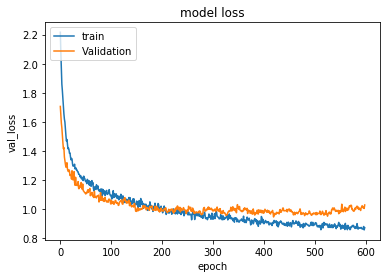

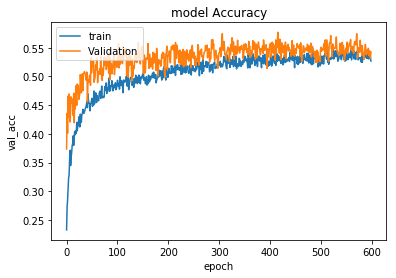

Loading Best Model
0.9802938719770946


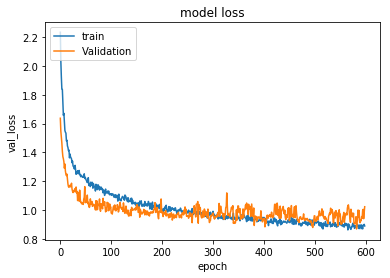

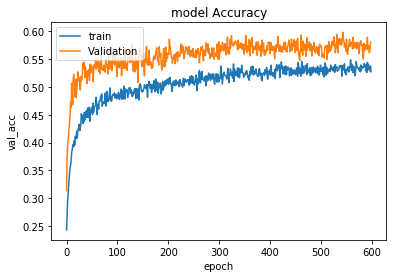

Loading Best Model
0.8896818193995596


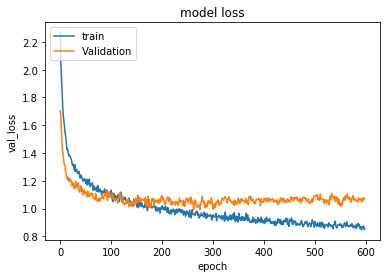

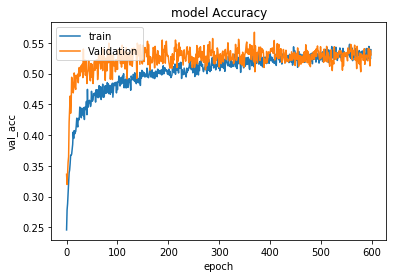

Loading Best Model
0.7332590895347082


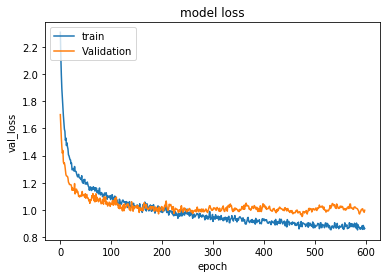

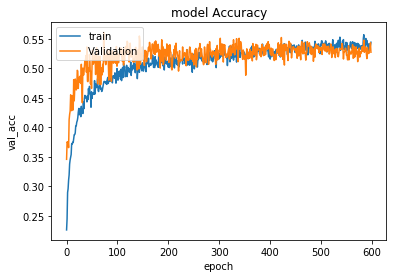

Loading Best Model
0.7322984861958973


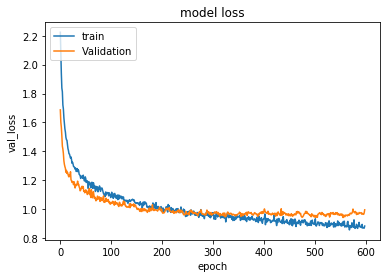

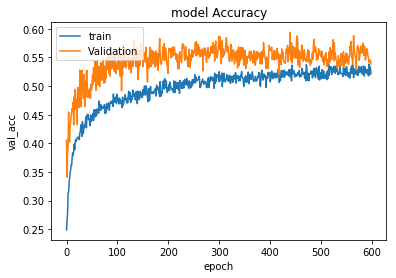

Loading Best Model
0.7157225539682381
MULTI WEIGHTED LOG LOSS : 0.81151 


In [26]:
from keras.callbacks import ModelCheckpoint

clfs = []
oof_preds = np.zeros((len(full_train_ss), len(classes)))
epochs = 600
batch_size = 100
checkPoint = ModelCheckpoint("./keras.model",monitor='val_loss',mode = 'min', save_best_only=True, verbose=0)
for fold_, (trn_, val_) in enumerate(folds.split(y_map, y_map)):
    x_train, y_train = full_train_ss[trn_], y_categorical[trn_]
    x_valid, y_valid = full_train_ss[val_], y_categorical[val_]
    
    model = build_model(dropout_rate=0.5,activation='tanh')    
    model.compile(loss=mywloss, optimizer='adam', metrics=['accuracy'])
    history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,shuffle=True,verbose=0,callbacks=[checkPoint])       
    
    plot_loss_acc(history)
    
    print('Loading Best Model')
    model.load_weights('./keras.model')
    # # Get predicted probabilities for each class
    oof_preds[val_, :] = model.predict_proba(x_valid,batch_size=batch_size)
    print(multi_weighted_logloss(y_valid, model.predict_proba(x_valid,batch_size=batch_size)))
    clfs.append(model)
    
print('MULTI WEIGHTED LOG LOSS : %.5f ' % multi_weighted_logloss(y_categorical,oof_preds))

## Examine the Confusion Matrix

First create a function to plot the confusion matrix:

In [27]:
# http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Next, compute the values for the confusion matrix:

In [28]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(y_map, np.argmax(oof_preds,axis=-1))
np.set_printoptions(precision=2)

Now, read the class names to put on the confusion matrix visualization:

In [31]:
sample_sub = pd.read_csv('../data/sample_submission.csv', engine='python')
class_names = list(sample_sub.columns[1:-1])
del sample_sub;gc.collect()

29

Finally, plot the normalized confusion matrix:

Normalized confusion matrix
[[8.68e-01 0.00e+00 6.62e-03 0.00e+00 0.00e+00 1.32e-02 0.00e+00 0.00e+00
  7.95e-02 0.00e+00 0.00e+00 0.00e+00 3.31e-02 0.00e+00]
 [0.00e+00 4.75e-01 0.00e+00 5.05e-02 7.68e-02 0.00e+00 4.24e-02 3.84e-02
  0.00e+00 1.94e-01 6.06e-03 9.90e-02 0.00e+00 1.82e-02]
 [7.58e-03 0.00e+00 9.68e-01 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
  5.41e-03 0.00e+00 0.00e+00 0.00e+00 1.95e-02 0.00e+00]
 [8.38e-04 1.62e-01 0.00e+00 1.84e-01 1.59e-01 8.38e-04 1.26e-01 4.69e-02
  0.00e+00 1.48e-01 5.87e-03 1.45e-01 0.00e+00 2.18e-02]
 [0.00e+00 1.42e-01 0.00e+00 7.65e-02 3.61e-01 0.00e+00 5.46e-02 2.73e-02
  0.00e+00 2.02e-01 0.00e+00 1.31e-01 0.00e+00 5.46e-03]
 [0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 9.67e-01 0.00e+00 0.00e+00
  3.33e-02 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]
 [0.00e+00 2.07e-01 0.00e+00 7.02e-02 1.40e-01 0.00e+00 1.78e-01 7.64e-02
  0.00e+00 2.44e-01 2.07e-03 7.44e-02 0.00e+00 8.26e-03]
 [9.80e-03 9.80e-03 0.00e+00 0.00e+00 0.00e+00 0.00e+00

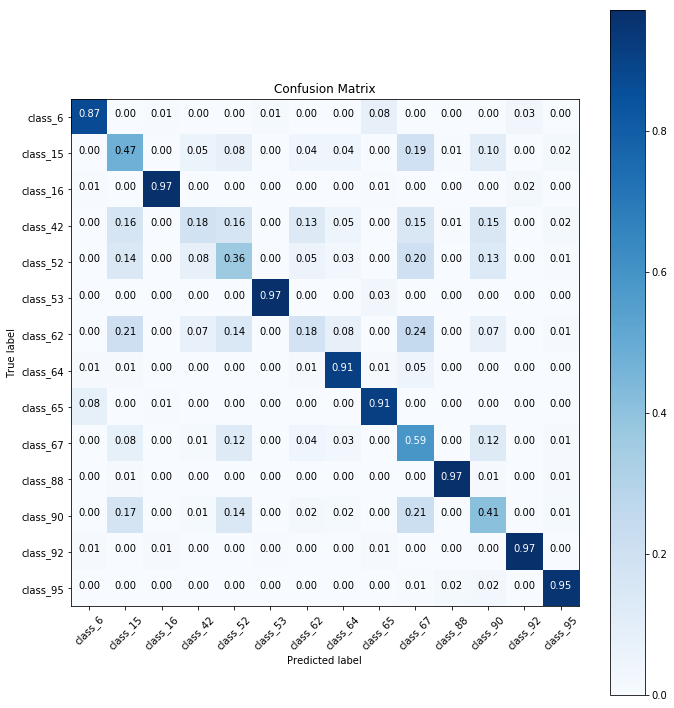

In [36]:
import itertools
%matplotlib inline
plt.figure(figsize=(10,10))
foo = plot_confusion_matrix(cnf_matrix, classes=class_names,normalize=True,
                      title='Confusion Matrix')

## Predictions on the Test Set

First, let's work on the sample:

In [57]:
meta_test = pd.read_csv('../data/test_set_metadata.csv', engine='python')

import time

true_classes = []
start = time.time()
chunks = 5000000
for i_c, df in enumerate(pd.read_csv('../data/test_set_sample.csv', engine='python', chunksize=chunks, iterator=True)):
    df['flux_ratio_sq'] = np.power(df['flux'] / df['flux_err'], 2.0)
    df['flux_by_flux_ratio_sq'] = df['flux'] * df['flux_ratio_sq']
    # Group by object id
    agg_test = df.groupby('object_id').agg(aggs)
    agg_test.columns = new_columns
    agg_test['mjd_diff'] = agg_test['mjd_max'] - agg_test['mjd_min']
    agg_test['flux_diff'] = agg_test['flux_max'] - agg_test['flux_min']
    agg_test['flux_dif2'] = (agg_test['flux_max'] - agg_test['flux_min']) / agg_test['flux_mean']
    agg_test['flux_w_mean'] = agg_test['flux_by_flux_ratio_sq_sum'] / agg_test['flux_ratio_sq_sum']
    agg_test['flux_dif3'] = (agg_test['flux_max'] - agg_test['flux_min']) / agg_test['flux_w_mean']

    del agg_test['mjd_max'], agg_test['mjd_min']
#     del df
#     gc.collect()
    
    # Merge with meta data
    full_test = agg_test.reset_index().merge(
        right=meta_test,
        how='left',
        on='object_id'
    )
    print('columns {}'.format(full_test.columns))
    full_test[full_train.columns] = full_test[full_train.columns].fillna(train_mean)
    full_test_ss = ss.transform(full_test[full_train.columns])
    # Make predictions
    preds = None
    for clf in clfs:
        if preds is None:
            preds = clf.predict_proba(full_test_ss) / folds.n_splits
        else:
            preds += clf.predict_proba(full_test_ss) / folds.n_splits
    
   # Compute preds_99 as the proba of class not being any of the others
    # preds_99 = 0.1 gives 1.769
    preds_99 = np.ones(preds.shape[0])
    for i in range(preds.shape[1]):
        preds_99 *= (1 - preds[:, i])
    
    # Store predictions
    preds_df = pd.DataFrame(preds, columns=class_names)
    preds_df['object_id'] = full_test['object_id']
    preds_df['class_99'] = 0.14 * preds_99 / np.mean(preds_99) 
    
    if i_c == 0:
        preds_df.to_csv('predictions_sample.csv',  header=True, mode='a', index=False)
    else: 
        preds_df.to_csv('predictions_sample.csv',  header=False, mode='a', index=False)
        
    del agg_test, full_test, preds_df, preds
    print('done')
#     if (i_c + 1) % 10 == 0:
    print('%15d done in %5.1f' % (chunks * (i_c + 1), (time.time() - start) / 60))

columns Index(['object_id', 'mjd_size', 'passband_min', 'passband_max',
       'passband_mean', 'passband_median', 'passband_std', 'flux_min',
       'flux_max', 'flux_mean', 'flux_median', 'flux_std', 'flux_skew',
       'flux_err_min', 'flux_err_max', 'flux_err_mean', 'flux_err_median',
       'flux_err_std', 'flux_err_skew', 'detected_mean', 'flux_ratio_sq_sum',
       'flux_ratio_sq_skew', 'flux_by_flux_ratio_sq_sum',
       'flux_by_flux_ratio_sq_skew', 'mjd_diff', 'flux_diff', 'flux_dif2',
       'flux_w_mean', 'flux_dif3', 'ra', 'decl', 'gal_l', 'gal_b', 'ddf',
       'hostgal_specz', 'hostgal_photoz', 'hostgal_photoz_err', 'distmod',
       'mwebv'],
      dtype='object')
done
        5000000 done in   0.2


In [34]:
z = pd.read_csv('predictions_sample.csv')

print(z.groupby('object_id').size().max())
print((z.groupby('object_id').size() > 1).sum())

z = z.groupby('object_id').mean()

z.to_csv('single_predictions_sample.csv', index=True)

1
0


In [39]:
z.sample(10)

,class_6,class_15,class_16,class_42,class_52,class_53,class_62,class_64,class_65,class_67,class_88,class_90,class_92,class_95,class_99
object_id,,,,,,,,,,,,,,,
29211,4.516065e-06,0.007562,0.000007,0.109001,0.297080,6.029399e-07,0.045927,0.000079,0.000125,0.045704,0.000671,0.489285,6.311933e-06,0.004547,0.145137
20068,5.931184e-06,0.006872,0.000008,0.131774,0.349931,6.165892e-08,0.075055,0.000069,0.000022,0.047142,0.001406,0.384868,4.056081e-06,0.002843,0.152767
18758,1.774340e-06,0.022918,0.000012,0.137461,0.155999,2.105437e-06,0.051645,0.003622,0.000063,0.103477,0.023030,0.473444,4.949388e-06,0.028319,0.152068
27052,1.094161e-06,0.014156,0.000022,0.102429,0.217395,9.359767e-07,0.059700,0.000858,0.000055,0.156608,0.011293,0.434263,4.868037e-06,0.003214,0.154456
21962,5.461269e-07,0.014014,0.000005,0.094214,0.220175,2.420164e-06,0.035535,0.000465,0.000046,0.095968,0.006375,0.529968,4.597076e-06,0.003227,0.142658
26502,1.743608e-06,0.010896,0.000215,0.113317,0.199905,6.595550e-06,0.047844,0.000384,0.000052,0.119069,0.030580,0.472190,3.124257e-05,0.005507,0.151115
173,3.868185e-07,0.026004,0.000001,0.086281,0.295098,3.034932e-09,0.069925,0.001629,0.000006,0.272395,0.001635,0.246903,3.658653e-08,0.000123,0.160880
32284,8.515730e-06,0.013969,0.000432,0.079102,0.033385,6.347307e-05,0.024654,0.001633,0.000169,0.019710,0.495725,0.168289,3.208936e-04,0.162538,0.148439
18146,3.284641e-07,0.011800,0.000007,0.108533,0.202459,1.186001e-06,0.037022,0.000548,0.000028,0.085391,0.025503,0.525184,7.186040e-06,0.003515,0.143976


In [46]:
predictions = z.idxmax(axis=1)

In [61]:
# cnf_matrix = confusion_matrix(y_map, np.argmax(oof_preds,axis=-1))


In [54]:
# y = true class
#test_confmat = confusion_matrix()

In [64]:
full_train

,mjd_size,passband_min,passband_max,passband_mean,passband_median,passband_std,flux_min,flux_max,flux_mean,flux_median,...,flux_by_flux_ratio_sq_sum,flux_by_flux_ratio_sq_skew,mjd_diff,flux_diff,flux_dif2,flux_w_mean,flux_dif3,hostgal_photoz,hostgal_photoz_err,mwebv
0,352,0,5,2.457386,2.0,1.720797,-1100.440063,660.626343,-123.096998,-89.477524,...,-9.601766e+08,-1.414322,873.7903,1761.066406,-14.306331,-327.742307,-5.373326,0.0000,0.0000,0.017
1,350,0,5,2.400000,2.0,1.746056,-14.735178,14.770886,-1.423351,-0.873033,...,-2.875087e+04,-3.454554,848.8198,29.506064,-20.730002,-4.884564,-6.040676,1.6267,0.2552,0.007
2,330,0,5,2.336364,2.0,1.758750,-19.159811,47.310059,2.267434,0.409172,...,1.046502e+05,5.989138,853.8455,66.469870,29.315018,25.373110,2.619697,0.2262,0.0157,0.021
3,351,0,5,2.378917,2.0,1.747328,-15.494463,220.795212,8.909206,1.035895,...,1.439125e+07,11.141069,853.7060,236.289675,26.521968,152.835617,1.546038,0.2813,1.1523,0.007
4,352,0,5,2.457386,2.0,1.720797,-16.543753,143.600189,7.145702,1.141288,...,3.015599e+06,7.908174,873.7903,160.143942,22.411225,87.856390,1.822792,0.2415,0.0176,0.024
5,330,0,5,2.336364,2.0,1.758750,-12.695161,71.678154,0.367212,0.208109,...,6.502524e+04,18.163484,853.8455,84.373315,229.767085,49.288884,1.711812,0.0000,0.0000,0.020
6,352,0,5,2.457386,2.0,1.720797,-13.854152,1448.715698,30.333023,0.337299,...,2.707323e+08,7.086625,873.7903,1462.569850,48.217082,947.492941,1.543621,0.1820,0.0304,0.019
7,352,0,5,2.457386,2.0,1.720797,-14.525748,34.559826,1.760026,0.623454,...,5.470282e+03,6.580398,873.7903,49.085574,27.889112,7.822647,6.274804,0.7014,0.0100,0.021
8,255,0,5,2.647059,3.0,1.646083,-13.367912,231.828339,19.228827,1.252908,...,2.892628e+07,5.587353,854.6558,245.196251,12.751493,169.993244,1.442388,0.3229,0.3360,0.027
9,255,0,5,2.647059,3.0,1.646083,-52.764721,30.658575,-0.085210,0.166696,...,2.755184e+04,11.510411,854.6558,83.423296,-979.035091,22.846253,3.651509,0.0000,0.0000,0.018
